In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from tqdm import tqdm

In [2]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [3]:
mtsamples = pd.read_csv('./mtsamples.csv')
mtsamples.head(3)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."


In [4]:
# collect and disregard datapoints that are associated with types of notes
cols_to_remove = [
    " Consult - History and Phy.",
    " SOAP / Chart / Progress Notes",
    " Discharge Summary",
    " Emergency Room Reports",
    " Office Notes",
    " Letters"
]
mtsamples = mtsamples[~mtsamples['medical_specialty'].isin(cols_to_remove)]

# remove rows with missing transcriptions
mtsamples = mtsamples.dropna(subset=['transcription'])
mtsamples['medical_specialty'].value_counts()

medical_specialty
 Surgery                       1088
 Cardiovascular / Pulmonary     371
 Orthopedic                     355
 Radiology                      273
 General Medicine               259
 Gastroenterology               224
 Neurology                      223
 Urology                        156
 Obstetrics / Gynecology        155
 ENT - Otolaryngology            96
 Neurosurgery                    94
 Hematology - Oncology           90
 Ophthalmology                   83
 Nephrology                      81
 Pediatrics - Neonatal           70
 Pain Management                 61
 Psychiatry / Psychology         53
 Podiatry                        47
 Dermatology                     29
 Cosmetic / Plastic Surgery      27
 Dentistry                       27
 Physical Medicine - Rehab       21
 Sleep Medicine                  20
 Endocrinology                   19
 Bariatrics                      18
 IME-QME-Work Comp etc.          16
 Chiropractic                    14
 Rheumatol

## BERT Approach

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from transformers import AdamW

In [6]:
# get data
x = mtsamples['transcription'].values
Y = mtsamples['medical_specialty'].values

print(x.shape)
print(Y.shape)

(4028,)
(4028,)


In [7]:
# encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y = le.fit_transform(Y)
print(Y.shape)

(4028,)


In [8]:
device = torch.device("mps")

# load pre-trained BERT
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(np.unique(Y)),
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [9]:
# load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-uncased",
    do_lower_case=True
)

### Dataset Creation

In [10]:
class TranscriptionClassificationDataset(Dataset):
    def __init__(self, transcriptions, specialties, tokenizer, max_len):
        self.transcriptions = transcriptions
        self.specialties = specialties
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.transcriptions)
    
    def __getitem__(self, item):
        transcription = str(self.transcriptions[item])
        specialty = self.specialties[item]

        encoding = self.tokenizer.encode_plus(
            transcription,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'transcription_text': transcription,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'specialty': torch.tensor(specialty, dtype=torch.long)
        }

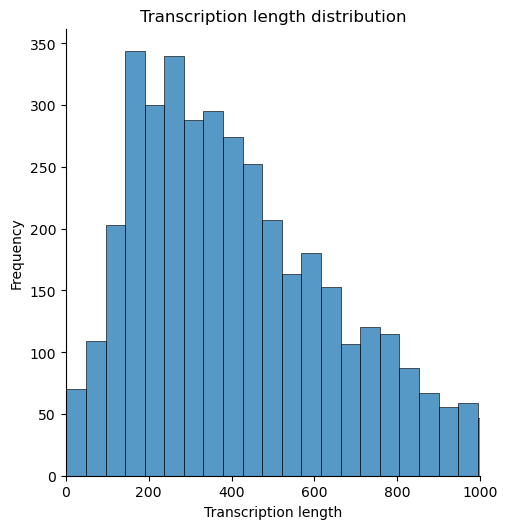

In [11]:
# plot distribution of transcription lengths
transcription_lengths = [len(x.split()) for x in mtsamples['transcription'].tolist()]
sns.displot(transcription_lengths)
plt.xlim([0, 1000])
plt.xlabel('Transcription length')
plt.ylabel('Frequency')
plt.title('Transcription length distribution')
plt.show()

In [12]:
# setup torch data loaders
x_train, x_val, Y_train, Y_val = train_test_split(x, Y, test_size=0.3)

train_data = TranscriptionClassificationDataset(
    transcriptions=x_train,
    specialties=Y_train,
    tokenizer=tokenizer,
    max_len=512
)

val_data = TranscriptionClassificationDataset(
    transcriptions=x_val,
    specialties=Y_val,
    tokenizer=tokenizer,
    max_len=512
)

train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)

val_dataloader = DataLoader(
    val_data,
    batch_size=32,
    shuffle=False
)

### Training

In [13]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=2e-5)

In [14]:
n_epochs = 1

for epoch in range(n_epochs):
    total_train_loss = 0
    model.train()
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        specialty = batch['specialty'].to(device)

        model.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=specialty
        )

        loss = outputs[0]
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    print(f'Epoch: {epoch + 1}')
    print(f'Training loss: {avg_train_loss}')

  0%|          | 0/89 [00:00<?, ?it/s]

/Users/kabirjolly/miniconda3/envs/cs224n/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 89/89 [1:42:08<00:00, 68.86s/it]

Epoch: 1
Training loss: 2.785619020462036


### Evaluation

In [25]:
model.eval()

val_preds = []
val_labels = []

for batch in tqdm(val_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    specialty = batch['specialty'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = specialty.to('cpu').numpy()

    val_preds.append(logits)
    val_labels.append(label_ids)

val_preds = np.concatenate(val_preds, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

preds = np.argmax(val_preds, axis=1).flatten()

  0%|          | 0/38 [00:00<?, ?it/s]/Users/kabirjolly/miniconda3/envs/cs224n/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 38/38 [01:21<00:00,  2.15s/it]


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

# plot confusion matrix
conf_mat = confusion_matrix(val_labels, preds)
print(conf_mat)
print(conf_mat.shape)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   1   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 309   0]
 [  0   0   0 ...   0  42   0]]
(33, 33)


<AxesSubplot: >

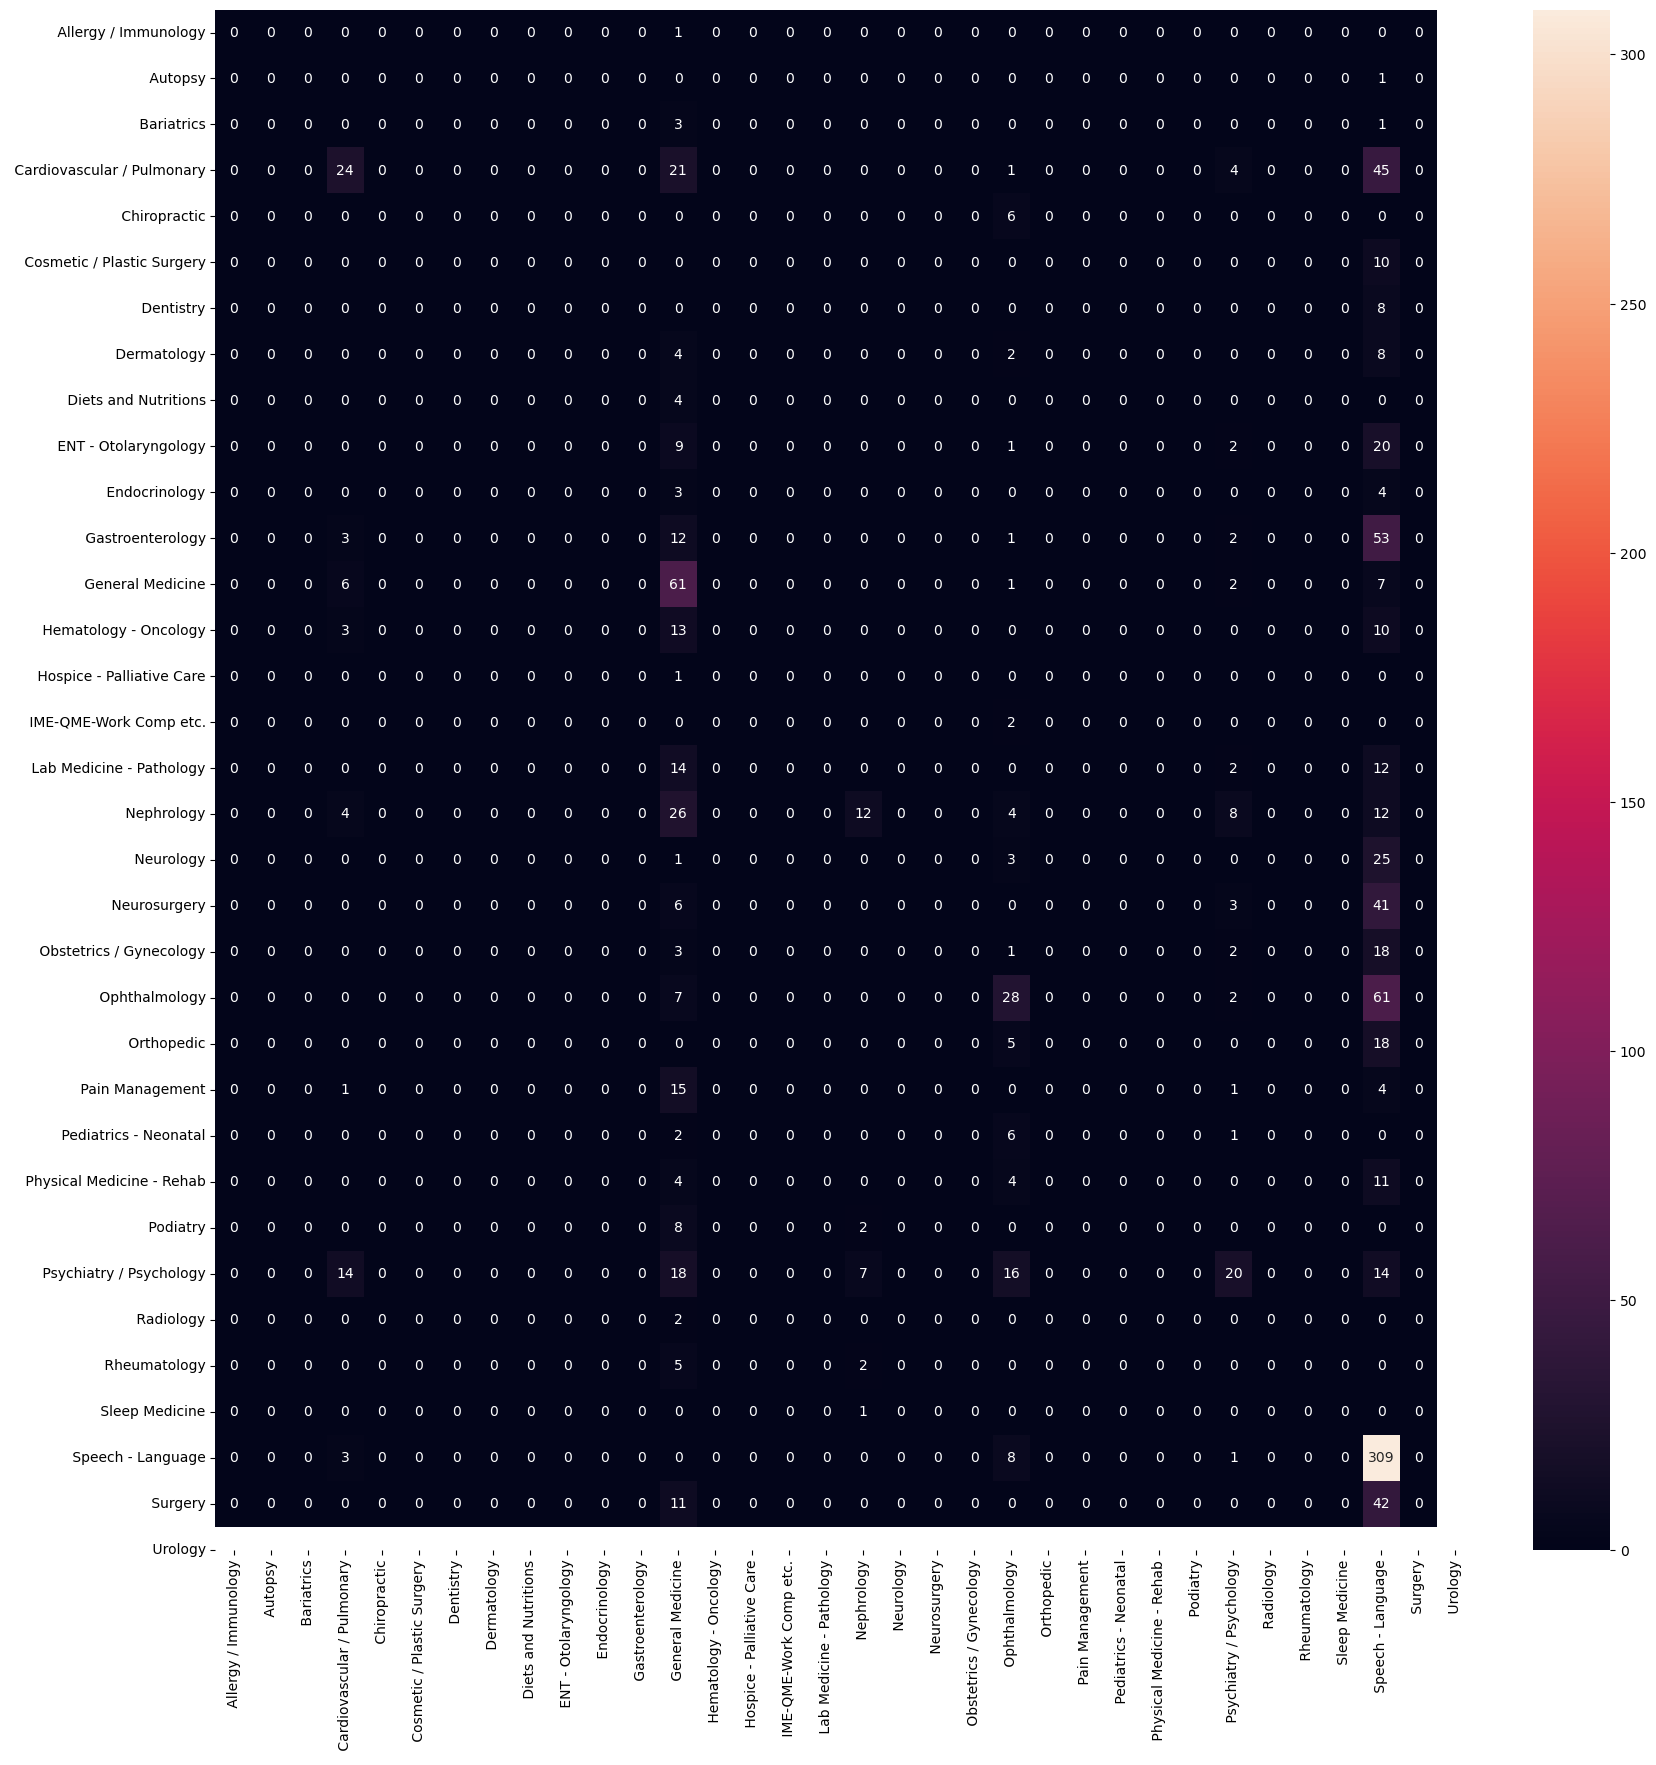

In [20]:
# plot confusion matrix using seaborn
class_labels = np.unique(mtsamples['medical_specialty'].values)
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(val_labels, preds, average='macro', zero_division=0))
print("Recall: ", recall_score(val_labels, preds, average='macro', zero_division=0))
print("F1 Score: ", f1_score(val_labels, preds, average='macro', zero_division=0))

Precision:  0.06937994702323601
Recall:  0.08180932612851911
F1 Score:  0.06430270401883048


In [29]:
print(classification_report(val_labels, preds, target_names=class_labels[1:], zero_division=0))

                             precision    recall  f1-score   support

                    Autopsy       0.00      0.00      0.00         1
                 Bariatrics       0.00      0.00      0.00         1
 Cardiovascular / Pulmonary       0.00      0.00      0.00         4
               Chiropractic       0.41      0.25      0.31        95
 Cosmetic / Plastic Surgery       0.00      0.00      0.00         6
                  Dentistry       0.00      0.00      0.00        10
                Dermatology       0.00      0.00      0.00         8
       Diets and Nutritions       0.00      0.00      0.00        14
       ENT - Otolaryngology       0.00      0.00      0.00         4
              Endocrinology       0.00      0.00      0.00        32
           Gastroenterology       0.00      0.00      0.00         7
           General Medicine       0.00      0.00      0.00        71
      Hematology - Oncology       0.24      0.79      0.37        77
  Hospice - Palliative Care      